# Violent Crime in Lockdown Britain

<h2> Scenerio </h2>
<p>During the coronavirus pandemic, the UK experienced several periods of legally restricted movement (‘Lockdowns’) where most of the population were ordered to stay at home. 
According to several authors (Ilesanmi et al., 2020, The Economist 2020, Piquero et al. 2021) lockdowns resulted in increased domestic violence, but did this result in an overall increase in recorded violent crime? </p>


In [1]:
# Import all the required libraries
import numpy as np
import pandas as pda

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
import itertools

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, sum, col, to_date

import statsmodels.api as sm

In [2]:
# Create a Spark context 

spark = SparkSession\
.builder\
.appName("Violent Crime in Lockdown Britain")\
.getOrCreate()

#Check we have a spark context: Should show the spark version and app name
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Violent Crime in Lockdown Britain>

<p> 
In order to work on the above scenerio we need to load the two datasets named all crime and locations into our spark dataframes 
</p>

In [ ]:
# Load crime dataset
crime_data = "http://unn-izje1.newnumyspace.co.uk/all_crimes21_hdr.txt.gz"
spark.sparkContext.addFile(crime_data)
crime_df = spark.read.csv("file://" + SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, inferSchema= True)

In [4]:
crime_df.show(1)


+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------------+-----------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|          LSOA name| Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------------+-----------+---------------------+-------+
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662|Aylesbury Vale 015C|Other crime|                 null|   null|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------------+-----------+---------------------+-------+
only showing top 1 row



In [5]:
# Load Lacations data set
location_data = "http://unn-izje1.newnumyspace.co.uk/LSOA_pop_v2.csv"
spark.sparkContext.addFile(location_data)
location_df = spark.read.csv("file://" + SparkFiles.get("LSOA_pop_v2.csv"), header=True, inferSchema= True)

In [6]:
location_df.show(5)

+----+---------------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
|date|      geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); measures: Value|
+----+------------

In [7]:
# Checking for the count of total crime types
crime_df.agg(count("Crime Type")).show()

+-----------------+
|count(Crime Type)|
+-----------------+
|         65078250|
+-----------------+



Question : What crime categories does the Police data use? </br>
Solution :In order to answer the above question, we need to do a group by on our crime data set to get all the categories used.

In [10]:
count_df = (crime_df
 .select("*")
 .groupBy("Crime Type")
 .agg(count("Month").alias("Total"))
 .orderBy("Total", ascending=False))

In [11]:
count_df.show(20)

+--------------------+--------+
|          Crime Type|   Total|
+--------------------+--------+
|Anti-social behav...|20211528|
|Violence and sexu...|11411540|
|Criminal damage a...| 5343182|
|         Other theft| 5206259|
|            Burglary| 4350252|
|       Vehicle crime| 4170769|
|         Shoplifting| 3227557|
|         Other crime| 2565111|
|        Public order| 2564695|
|               Drugs| 1682486|
|       Violent crime| 1673219|
|       Bicycle theft|  735689|
|Theft from the pe...|  714621|
|             Robbery|  696008|
|Possession of wea...|  283189|
|Public disorder a...|  242145|
+--------------------+--------+



<p> As we can see above that in total it uses 16 crime categories in entire dataset. </p>

In [16]:
consistent_df = (crime_df
 .select("*")
 .where("Month == '2011-07'")
 .groupBy("Month","Crime Type")
 .agg(count("Month").alias("Total"))
 .orderBy("Total", ascending=False))

In [23]:
consistent_df.show(30)

+-------+--------------------+------+
|  Month|          Crime Type| Total|
+-------+--------------------+------+
|2011-07|Anti-social behav...|277632|
|2011-04|Anti-social behav...|277010|
|2011-08|Anti-social behav...|267997|
|2011-06|Anti-social behav...|248928|
|2013-07|Anti-social behav...|245263|
|2011-05|Anti-social behav...|243229|
|2011-03|Anti-social behav...|241110|
|2011-10|Anti-social behav...|239285|
|2012-08|Anti-social behav...|237475|
|2020-05|Anti-social behav...|230889|
|2020-04|Anti-social behav...|227899|
|2012-07|Anti-social behav...|226358|
|2011-09|Anti-social behav...|224113|
|2013-08|Anti-social behav...|223624|
|2012-03|Anti-social behav...|220822|
|2014-07|Anti-social behav...|218190|
|2012-05|Anti-social behav...|218172|
|2011-02|Anti-social behav...|206801|
|2012-06|Anti-social behav...|204751|
|2011-01|Anti-social behav...|201792|
|2010-12|Anti-social behav...|201016|
|2012-09|Anti-social behav...|200972|
|2013-06|Anti-social behav...|200337|
|2012-10|Ant

<p> 
    Question Have the same categories been used consistently? </br>
    Solution : In order to answer the above question we need to compare the categories for minimum of any three years. Ideally, 
    the categories might change at any instance.
    
    
    
</p>    

In [61]:
# Loading the data for the year 2011
year1_df = (crime_df
 .select("*")
 .where("Month like '2011%'")
 .groupBy("Month","Crime Type")
 .agg(count("Crime Type").alias("Total"))
 .orderBy("Total", ascending=False)) 
year1_df.groupBy("Crime Type").agg(count("Month").alias("Total")).orderBy("Total", ascending=False).show(50)


+--------------------+-----+
|          Crime Type|Total|
+--------------------+-----+
|            Burglary|   12|
|             Robbery|   12|
|       Vehicle crime|   12|
|         Other crime|   12|
|       Violent crime|   12|
|Anti-social behav...|   12|
|Criminal damage a...|    4|
|Public disorder a...|    4|
|         Other theft|    4|
|         Shoplifting|    4|
|               Drugs|    4|
+--------------------+-----+



<p>  There are total 11 crime categories in 2011
    
</p>    

In [60]:
# Loading the data for the year 2012
year2_df = (crime_df
 .select("*")
 .where("Month like '2012%'")
 .groupBy("Month","Crime Type")
 .agg(count("Crime Type").alias("Total"))
 .orderBy("Total", ascending=False)) 
year2_df.groupBy("Crime Type").agg(count("Month").alias("Total")).orderBy("Total", ascending=False).show(50)


+--------------------+-----+
|          Crime Type|Total|
+--------------------+-----+
|       Violent crime|   12|
|            Burglary|   12|
|Criminal damage a...|   12|
|Public disorder a...|   12|
|         Other crime|   12|
|         Shoplifting|   12|
|               Drugs|   12|
|Anti-social behav...|   12|
|             Robbery|   12|
|       Vehicle crime|   12|
|         Other theft|   12|
+--------------------+-----+



<p>  There are total 11 crime categories in 2012
    
</p>    

In [71]:
# Loading the data for the year 2017
year3_df = (crime_df
 .select("*")
 .where("Month like '2017%'")
 .groupBy("Month","Crime Type")
 .agg(count("Crime Type").alias("Total"))
 .orderBy("Total", ascending=False)) 
year3_df.groupBy("Crime Type").agg(count("Month").alias("Total")).orderBy("Total", ascending=False).show(50)

+--------------------+-----+
|          Crime Type|Total|
+--------------------+-----+
|        Public order|   12|
|       Bicycle theft|   12|
|         Other crime|   12|
|               Drugs|   12|
|         Shoplifting|   12|
|            Burglary|   12|
|             Robbery|   12|
|Criminal damage a...|   12|
|Theft from the pe...|   12|
|         Other theft|   12|
|Violence and sexu...|   12|
|Anti-social behav...|   12|
|Possession of wea...|   12|
|       Vehicle crime|   12|
+--------------------+-----+



<p>  There are total 14 crime categories in 2017.
     By comparing the 2011,2012,2017 years it is evident that crime categories have been changed but not constant. We can say that if there is atleast one diffrent category was created in any of the year it shows as they are not constant.
    
</p>    

<p> Question :	Are levels of violent crime constant, increasing, or decreasing </br>
    Solution : In order to answer this question, we need to get the data of category Violence and Sexual offences from crim data frame and do a group by of month and get a count of crimes of repective dates. As spark does not support graphs, we need to convert into pandas data frame to plot the graph
    
    
</p>    

In [13]:
# Doing a group by Month of Violence and sexual offences
viol_cr_df=crime_df.select("Crime type","Month").where(crime_df['Crime type'] =='Violence and sexual offences').orderBy("Month", ascending=False)

In [14]:
crim_trend=viol_cr_df.select('Month','Crime type').groupBy("Month").count()
 

In [12]:
crim_trend.head()

Row(Month='2020-06', count=158701)

In [15]:
# Converting into pandas for graphs
pdf=crim_trend.toPandas()
pdf


,Month,count
0,2020-06,158701
1,2013-05,57031
2,2019-10,158257
3,2020-12,148517
4,2018-10,158899
...,...,...
92,2020-10,158725
93,2017-01,108513
94,2018-09,151099
95,2018-07,166579


In [16]:
# Date conversion to draw graphs
pdf.Month = pdf.Month.astype('datetime64[ns]')
pdf2 = pdf.set_index(pda.to_datetime(pdf.Month))
pdf2

,Month,count
Month,,
2020-06-01,2020-06-01,158701
2013-05-01,2013-05-01,57031
2019-10-01,2019-10-01,158257
2020-12-01,2020-12-01,148517
2018-10-01,2018-10-01,158899
...,...,...
2020-10-01,2020-10-01,158725
2017-01-01,2017-01-01,108513
2018-09-01,2018-09-01,151099


In [17]:
# Soring index
pdf2.sort_index(inplace = True)

In [18]:
plt.figsize=(20, 6)

pdf2.plot(y='count', x='Month',marker='.', linestyle='-', linewidth=0.5,\
              subplots=False,
              label='Violent Crime Trend',
              title='Crime Data')
plt.ylabel('Total')

Text(0, 0.5, 'Total')

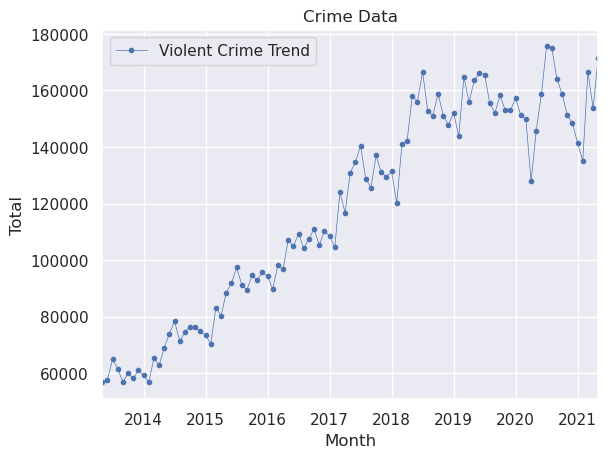

In [19]:
# Plotting a graph
plt.show()

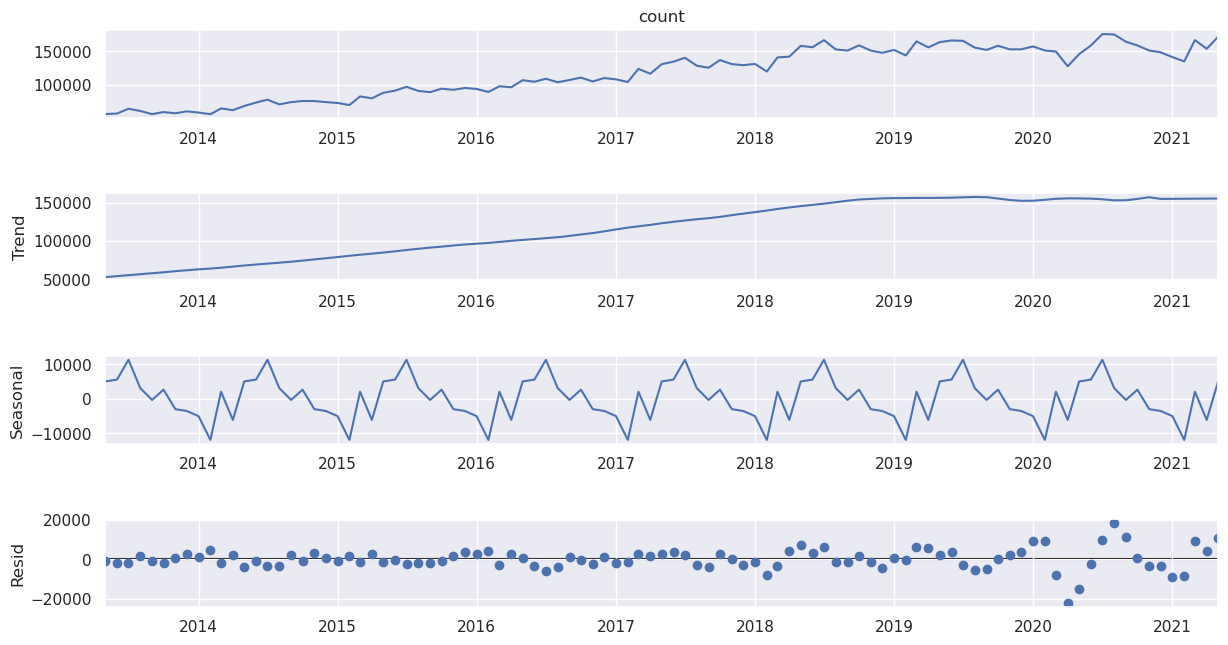

In [20]:
# Seasonal trend
decomposition = sm.tsa.seasonal_decompose(pdf2['count'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

<p> Based on the above graphs it is evident that violent crimes were increased constantly from year 2014 till starting of year 2020. However there is a slight dip in the curve in the mid of 2020 and it increased again which resulted in a maximum number of crimes . Hence the levels of crimes are not stable. 
    
    
 </p>   

<p>
    Question 4.: Using data prior to the first lockdown predict violent crime levels for April 2020 </br>
    Question 5.	Compare predicted crime levels with actuals, and so determine whether significant changes to violent crime                     occurred </br>
    Solution : In order to get the above results we need to implement Visualization of Time Series and make it stationary.
                   After doing that we can split into two data sets training and test dataset\dataframe and do some forecasts                  using Dickey-Fuller Test .
    
    
</p>    

In [21]:
# Taking the data greater than  2013 to 2020 because first violent crime occured after 2013. 
pdf3 = pdf2[(pdf2.Month.dt.year > 2013) & (pdf2.Month.dt.year < 2021) ] 
pdf3

,Month,count
Month,,
2014-01-01,2014-01-01,59291
2014-02-01,2014-02-01,56798
2014-03-01,2014-03-01,65372
2014-04-01,2014-04-01,62825
2014-05-01,2014-05-01,69063
...,...,...
2020-08-01,2020-08-01,174980
2020-09-01,2020-09-01,164204
2020-10-01,2020-10-01,158725


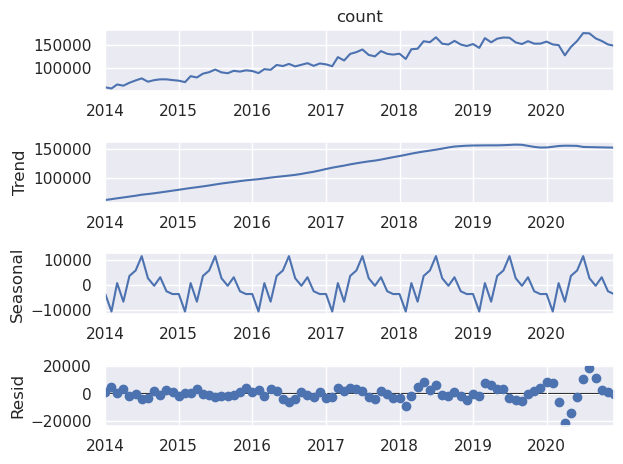

In [22]:
# Seasonal trend
decomposition = sm.tsa.seasonal_decompose(pdf3['count'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

In [23]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    plt.clf()
    #Determing rolling statistics
    rolmean = pda.Series(timeseries).rolling(window=12).mean() 
    rolstd = pda.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

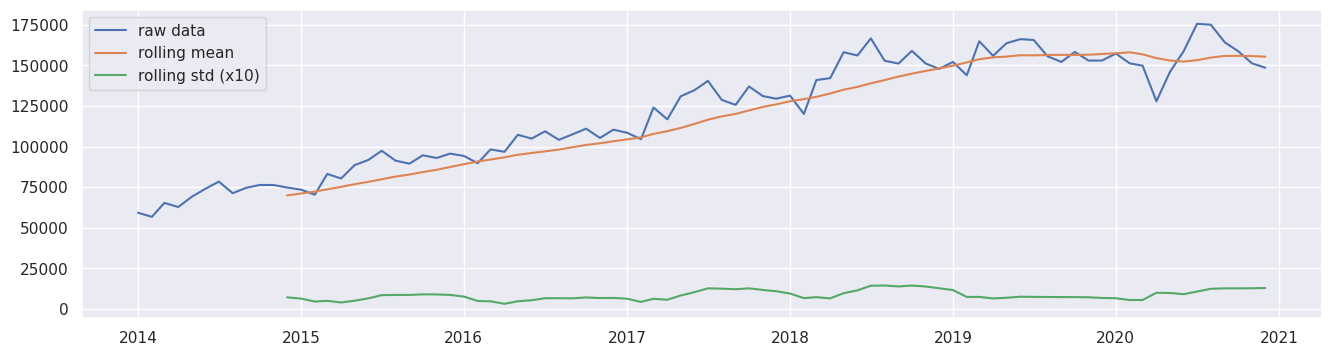

In [24]:
pda.options.display.float_format = '{:.8f}'.format
test_stationarity(pdf3['count'],'raw data')

In [25]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [26]:
ADF_test(pdf3['count'],'raw data')

 > Is the raw data stationary ?
Test statistic = -1.799
P-value = 0.381
Critical values :
	1%: -3.526004646825607 - The data is not stationary with 99% confidence
	5%: -2.9032002348069774 - The data is not stationary with 95% confidence
	10%: -2.5889948363419957 - The data is not stationary with 90% confidence


<Figure size 640x480 with 0 Axes>

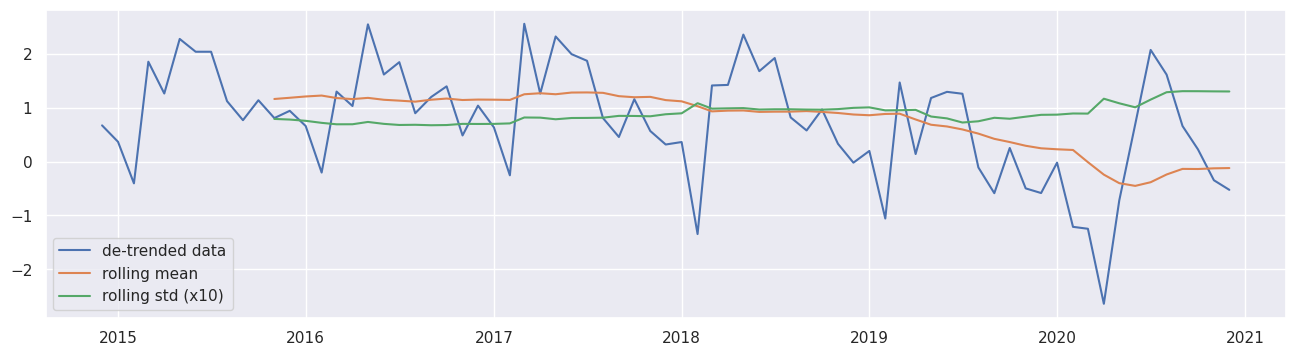

 > Is the de-trended data stationary ?
Test statistic = -0.294
P-value = 0.926
Critical values :
	1%: -3.5443688564814813 - The data is not stationary with 99% confidence
	5%: -2.9110731481481484 - The data is not stationary with 95% confidence
	10%: -2.5931902777777776 - The data is not stationary with 90% confidence


In [27]:
# Detrending
y = pdf3['count']
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

<Figure size 640x480 with 0 Axes>

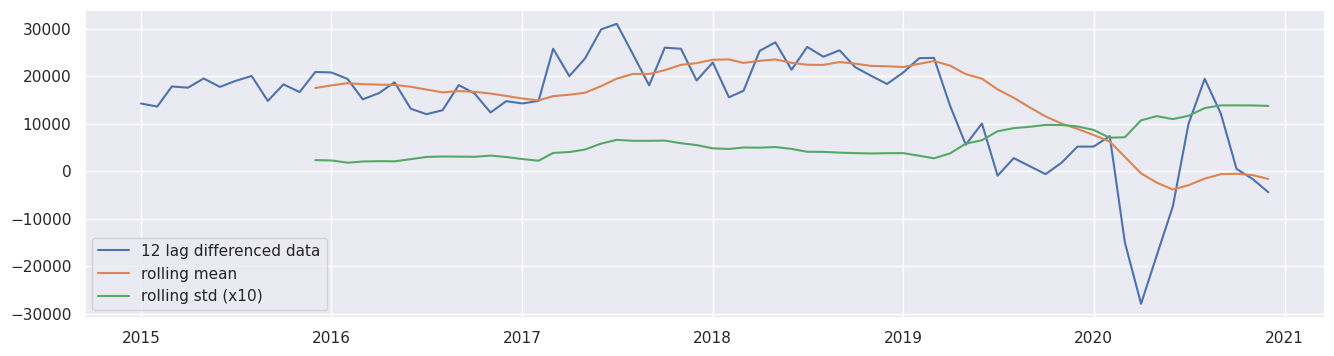

 > Is the 12 lag differenced data stationary ?
Test statistic = -1.133
P-value = 0.702
Critical values :
	1%: -3.5319549603840894 - The data is not stationary with 99% confidence
	5%: -2.905755128523123 - The data is not stationary with 95% confidence
	10%: -2.5903569458676765 - The data is not stationary with 90% confidence


In [28]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

<Figure size 640x480 with 0 Axes>

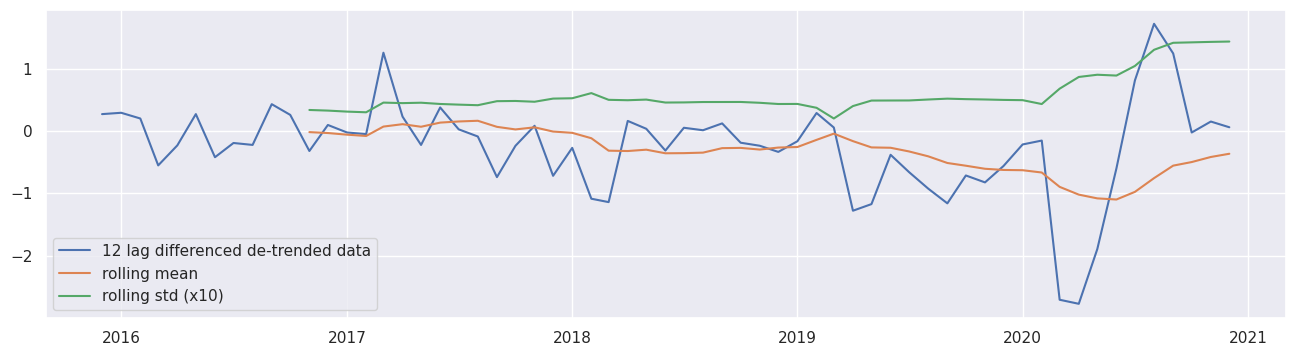

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -4.437
P-value = 0.000
Critical values :
	1%: -3.5463945337644063 - The data is  stationary with 99% confidence
	5%: -2.911939409384601 - The data is  stationary with 95% confidence
	10%: -2.5936515282964665 - The data is  stationary with 90% confidence


In [29]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')

ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

<p> As the data is stationary now we can perform our prediction from April 2020 </p>

In [30]:
y=y_12lag_detrend

In [31]:
y_to_train = y[:'2020-03-31'] # dataset to train
y_to_test = y['2020-04-01': ] # last X months for test  
y_to_val = y_to_test

In [32]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

p = d = q = range(0, 2)
seasonal_period = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [33]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(y_to_train,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:104.8207943089403
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:105.72297987670996
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:296.8090646827078
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1877.654276738394
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:104.87705592759775
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:102.43847603973822
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:281.98659082608174
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:281.96832102195424
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:94.79134955601441
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:94.55594181555175
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:292.23955079022124
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2131.0071926139212
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:93.81700797652749
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:91.13353559595062
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:278.89515237262475
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:277.4683010256864
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:115.03776099243352
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:106.27239421463932


In [34]:
order = (0, 0, 0) #Using Values from the previous step
seasonal_order = (0, 0, 1, 12)
model = sm.tsa.statespace.SARIMAX(y_to_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = model.fit()

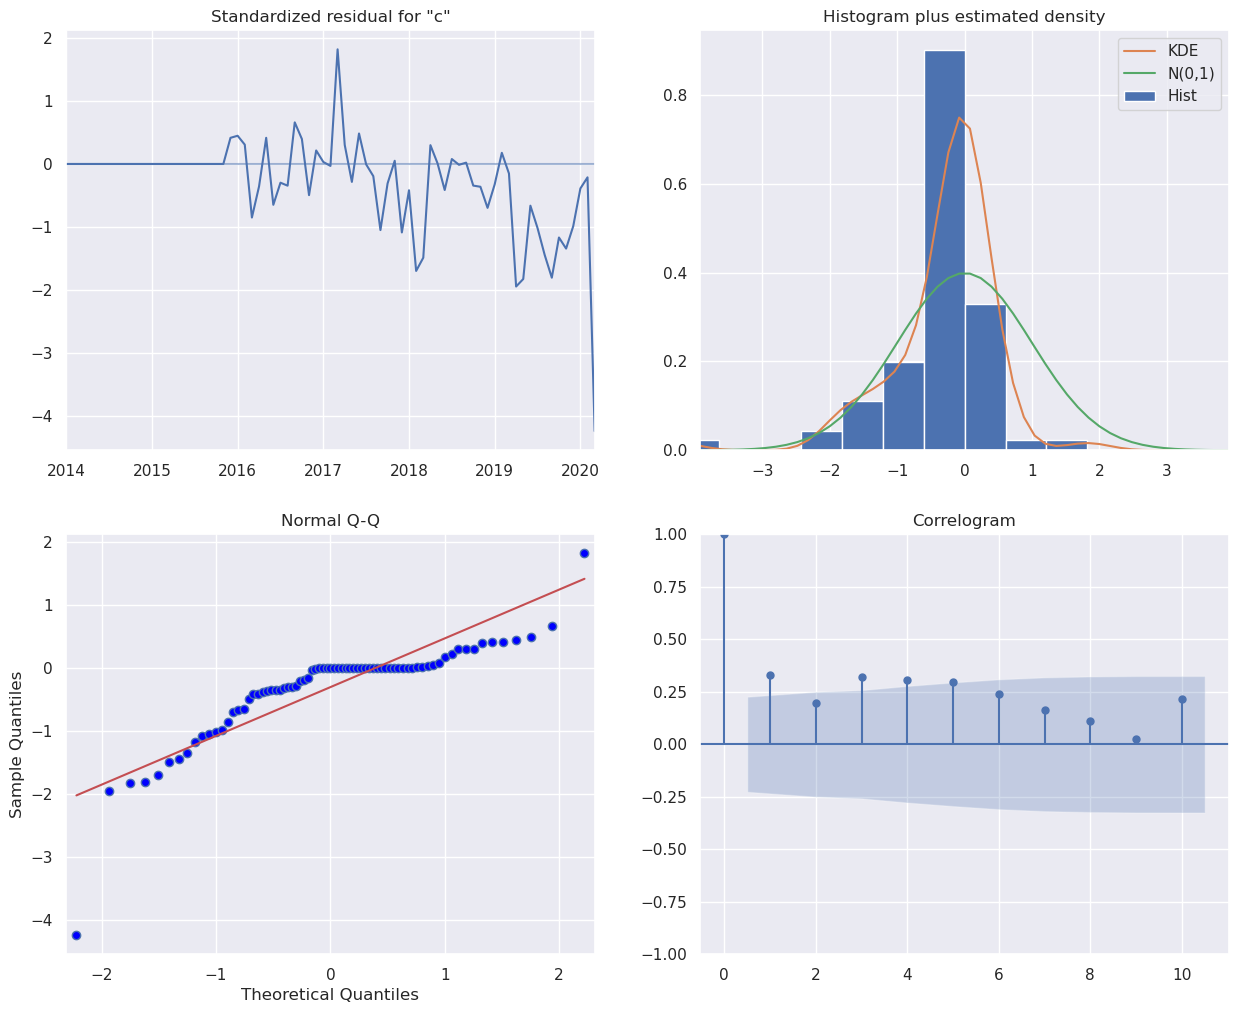

In [35]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [36]:
pred_uc = results.get_forecast(steps=12)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
pred_ci = pred_uc.conf_int()

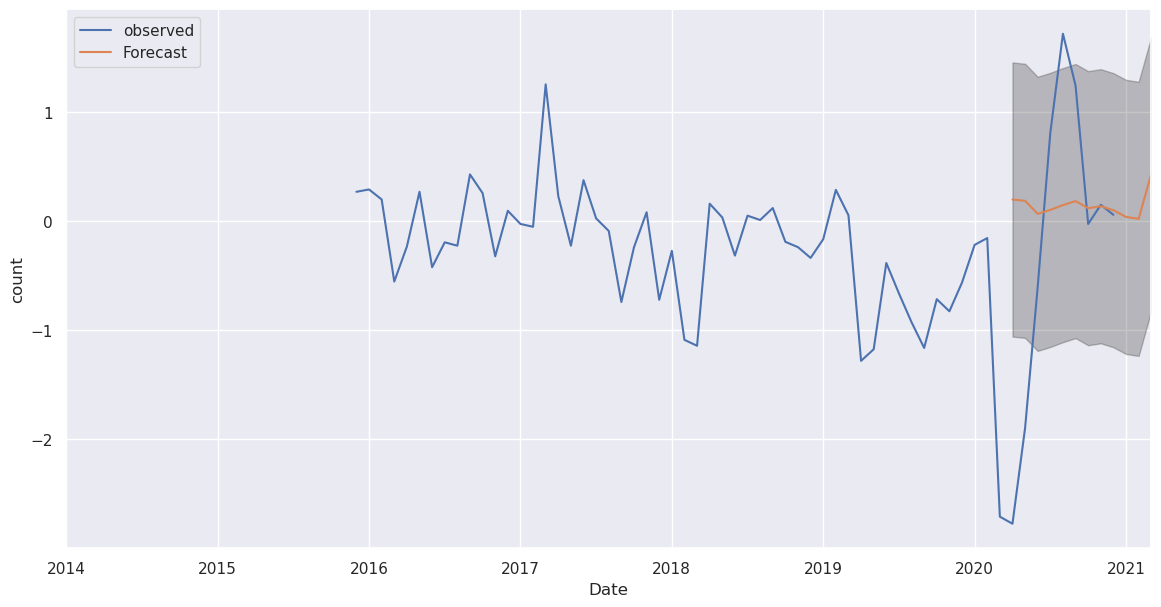

In [37]:
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

In [38]:
# Produce the forcasted tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')

In [39]:
final_table.head(12)

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2020-04-01,0.19933528,-1.05815448,1.45682505
1,2020-05-01,0.18713395,-1.07035581,1.44462372
2,2020-06-01,0.06782527,-1.18966449,1.32531504
3,2020-07-01,0.10423806,-1.15325171,1.36172782
4,2020-08-01,0.14790849,-1.10958127,1.40539826
5,2020-09-01,0.18501130,-1.07247847,1.44250106
6,2020-10-01,0.11961007,-1.13787969,1.37709984
7,2020-11-01,0.13763230,-1.11985746,1.39512207
8,2020-12-01,0.10113357,-1.15635619,1.35862333
9,2021-01-01,0.03986008,-1.21762968,1.29734984


In [40]:
y_to_test.head(12)

Month
2020-04-01   -2.77519573
2020-05-01   -1.89706826
2020-06-01   -0.60172282
2020-07-01    0.81195856
2020-08-01    1.72003232
2020-09-01    1.24410536
2020-10-01   -0.02520384
2020-11-01    0.15084966
2020-12-01    0.05904624
Name: count, dtype: float64

<p> From the above graphs we can predict that there is an increase in the crime levels in April 2020 based on past data.
    By comparing predicted crime with actuals we can find that there is not much significant impact on the data of violence     crimes.
    
    
    
</p>     

<p>  Question : The Leicester region was put in a local lockdown in July 2020. Verify your findings (if any) with respect to                   that region only. </br>
     Solution : To answer this question, we need to first get the data related to Leicester region from locations data set.                     After that we need to join this dataframe with the crime data frame having fileterd with greater than July 2020                 to get related data.
                As the main scenerio is all about the crimes so we can find out how many crimes had taken place post July 2020.
    
    
    
    
 </p>
    

In [41]:
leicester_df =location_df.select("*").where("geography like 'Leicester %'")

In [63]:
combine_df = leicester_df.join(crime_df,leicester_df['geography code'] ==  crime_df['LSOA code'],"inner")

In [65]:
jpandas=combine_df.toPandas()

In [72]:
# Taking data as per the requirement
filtered_df = combine_df.select(to_date(col("Month"),"yyyy-MM").alias("date"),'*')\
.where(combine_df.Month >= '2020-07')\
.groupBy('Month').count().orderBy('Month')

In [73]:
final_df = filtered_df.toPandas()

In [45]:
print(final_df)

     Month  count
0  2020-08   4189
1  2020-09   4021
2  2020-10   4013
3  2020-11   3945
4  2020-12   3494
5  2021-01   3353
6  2021-02   3214
7  2021-03   3934
8  2021-04   3856
9  2021-05   3975


In [74]:
plt.figsize=(20, 6)

final_df.plot(y='count', x='Month',marker='.', linestyle='-', linewidth=0.5,\
              subplots=False,
              label='Violence Vs Total',
              title='Leicester Region Data')
plt.ylabel('Total')

Text(0, 0.5, 'Total')

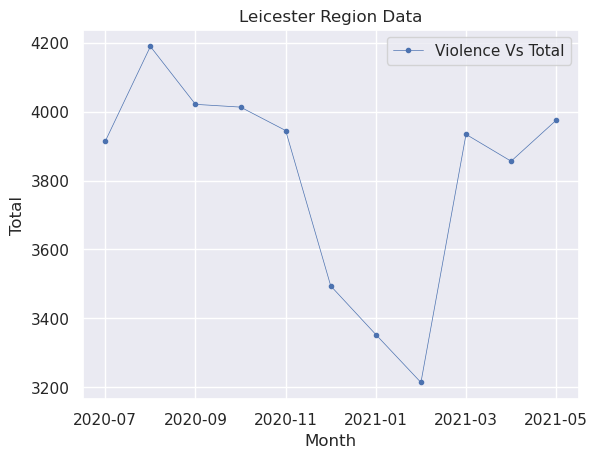

In [75]:
# Plotting graph
plt.show()

<p> Based on the above graph, we can find that the more number of crimes had taken place on 2020-08 and there is a constant decrease in the levels of crimes taken place timm 2021-02. Post that the levels of crime increased and decreased.
    
</p>